Recently, deep learning methods such as recurrent neural networks and one-dimensional convolutional neural networks, or CNNs, have been shown to provide state-of-the-art results on challenging activity recognition tasks with little or no data feature engineering, instead using feature learning on raw data. 

## 24.1 Tutorial Overview
This tutorial is divided into four parts; they are:
1. Activity Recognition Using Smartphones Dataset 
2. CNN for Activity Recognition
3. Tuned CNN Model
4. Multi-headed CNN Model

## 24.2 Activity Recognition Using Smartphones Dataset

Human Activity Recognition, or HAR for short, is the problem of predicting what a person is doing based on a trace of their movement using sensors. A standard human activity recognition dataset is the Activity Recognition Using Smartphones made available in 2012. For more information on this dataset, see Chapter 22.

## 24.3 CNN for Activity Recognition


The benefit of using CNNs for sequence classification is that they can learn from the raw time series data directly, and in turn do not require domain expertise to manually engineer input features.

1. Load Data
2. Fit and Evaluate Model 
3. Summarize Results
4. Complete Example

### 24.3.2 Fit and Evaluate Model

Now that we have the data loaded into memory ready for modeling, we can define, fit, and evaluate a 1D CNN model. We can define a function named evaluate model() that takes the train and test dataset, fits a model on the training dataset, evaluates it on the test dataset, and returns an estimate of the model’s performance. 

This is exactly how we have loaded the data, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features. The output for the model will be a six-element vector containing the probability of a given window belonging to each of the six activity types. 

The model is defined as a Sequential Keras model, for simplicity. We will define the model as having two 1D CNN layers, followed by a dropout layer for regularization, then a pooling layer. It is common to define CNN layers in groups of two in order to give the model a good chance of learning features from the input data. CNNs learn very quickly, so the dropout layer is intended to help slow down the learning process and hopefully result in a better final model. The pooling layer reduces the learned features to 1 their size, consolidating them to only the 4
most essential elements. After the CNN and pooling, the learned features are flattened to one long vector and pass through a fully connected layer before the output layer used to make a prediction. The fully connected layer ideally provides a buffer between the learned features and the output with the intent of interpreting the learned features before making a prediction. 

For this model, we will use a standard configuration of 64 parallel feature maps and a kernel size of 3. The feature maps are the number of times the input is processed or interpreted, whereas the kernel size is the number of input time steps considered as the input sequence is read or processed onto the feature maps. 


The model is fit for a fixed number of epochs, in this case 10, and a batch size of 32 samples will be used, where 32 windows of data will be exposed to the model before the weights of the model are updated.

### 24.3.3 Summarize Results

We cannot judge the skill of the model from a single evaluation. The reason for this is that neural networks are stochastic, meaning that a different specific model will result when training the same model configuration on the same data.

We will repeat the evaluation of the model multiple times, then summarize the performance of the model across each of those runs. For example, we can call evaluate model() a total of 10 times. 

In [2]:
# cnn model for the har dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment()

W0702 13:17:32.879446 4477576640 deprecation_wrapper.py:119] From /Users/Jianhua/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0702 13:17:32.942072 4477576640 deprecation_wrapper.py:119] From /Users/Jianhua/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0702 13:17:32.965922 4477576640 deprecation_wrapper.py:119] From /Users/Jianhua/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0702 13:17:33.043581 4477576640 deprecation_wrapper.py:119] From /Users/Jianhua/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_defa

>#1: 90.159
>#2: 91.822
>#3: 91.619
>#4: 91.042
>#5: 91.822
>#6: 89.956
>#7: 91.144
>#8: 89.583
>#9: 91.483
>#10: 90.295
[90.15948422124194, 91.82219205972176, 91.61859518154056, 91.04173736002714, 91.82219205972176, 89.95588734306074, 91.14353579911774, 89.58262639972854, 91.48286392941975, 90.29521547336275]
Accuracy: 90.892% (+/-0.786)


Finally, the sample of scores is printed followed by the mean and standard deviation. We can see that the model performed well achieving a classification accuracy of about 90.9% trained on the raw dataset, with a standard deviation of about 1.3. This is a good result, considering that the original paper published a result of 89%, trained on the dataset with heavy domain-specific feature engineering, not the raw dataset.

## 24.4 Tuned CNN Model
1. Data Preparation 
2. Number of Filters 
3. Size of Kernel


Standardization refers to shifting the distribution of each variable such that it has a mean of zero and a standard deviation of 1. It really only makes sense if the distribution of each variable is Gaussian. We can quickly check the distribution of each variable by plotting a histogram of each variable in the training dataset. A minor difficulty in this is that the data has been split into windows of 128 time steps, with a 50% overlap. Therefore, in order to get a fair idea of the data distribution, we must first remove the duplicated observations (the overlap), then remove the windowing of the data.

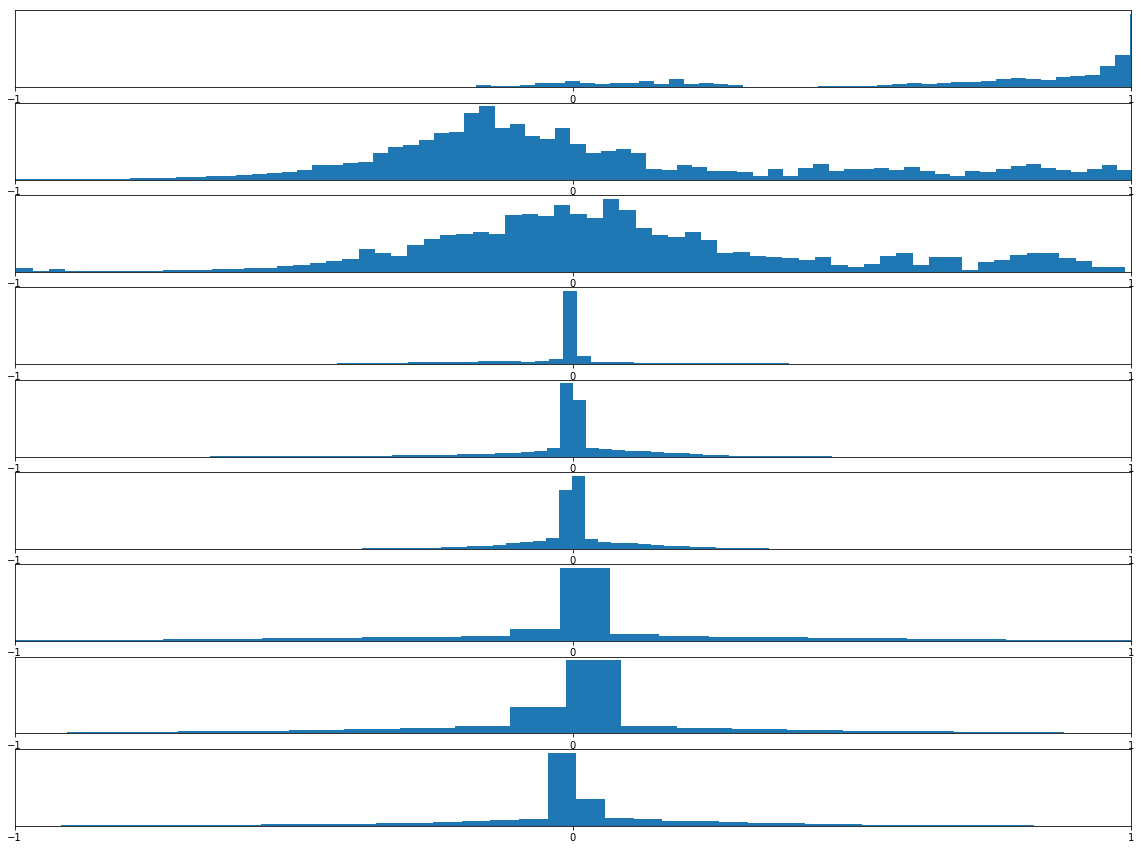

In [6]:
# plot distributions for the har dataset
from numpy import dstack
from pandas import read_csv
from keras.utils import to_categorical
from matplotlib import pyplot
%matplotlib inline
pyplot.rcParams['figure.figsize'] = (20, 15)

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	pyplot.figure()
	for i in range(longX.shape[1]):
		# create figure
		ax = pyplot.subplot(longX.shape[1], 1, i+1)
		ax.set_xlim(-1, 1)
		# create histogram
		pyplot.hist(longX[:, i], bins=100)
		# simplify axis remove clutter
		pyplot.yticks([])
		pyplot.xticks([-1,0,1])
	pyplot.show()

# load data
trainX, trainy, testX, testy = load_dataset()
# plot histograms
plot_variable_distributions(trainX)

We can see that each variable has a Gaussian-like distribution, except perhaps the first variable (Total Acceleration x). The distributions of total acceleration data is flatter than the body data, which is more pointed.

The data is sufficiently Gaussian-like to explore whether a standardization transform will help the model extract salient signal from the raw observations. The function below named scale_data() can be used to standardize the data prior to fitting and evaluating the model.

>p=False #1: 90.601
>p=False #2: 91.381
>p=False #3: 91.856
>p=False #4: 90.567
>p=False #5: 89.481
>p=False #6: 90.940
>p=False #7: 90.499
>p=False #8: 89.718
>p=False #9: 89.786
>p=False #10: 90.668
>p=True #1: 91.856
>p=True #2: 91.924
>p=True #3: 90.601
>p=True #4: 91.076
>p=True #5: 90.601
>p=True #6: 90.804
>p=True #7: 92.704
>p=True #8: 90.329
>p=True #9: 92.094
>p=True #10: 91.211
[[90.60061079063453, 91.38106549032915, 91.85612487275195, 90.56667797760434, 89.48082796063794, 90.93993892093654, 90.49881235154395, 89.71835765184933, 89.78622327790974, 90.66847641669494], [91.85612487275195, 91.92399049881234, 90.60061079063453, 91.07567017305735, 90.60061079063453, 90.80420766881574, 92.70444519850696, 90.32914828639295, 92.09365456396336, 91.21140142517815]] [False, True]
Param=False: 90.550% (+/-0.706)
Param=True: 91.320% (+/-0.743)


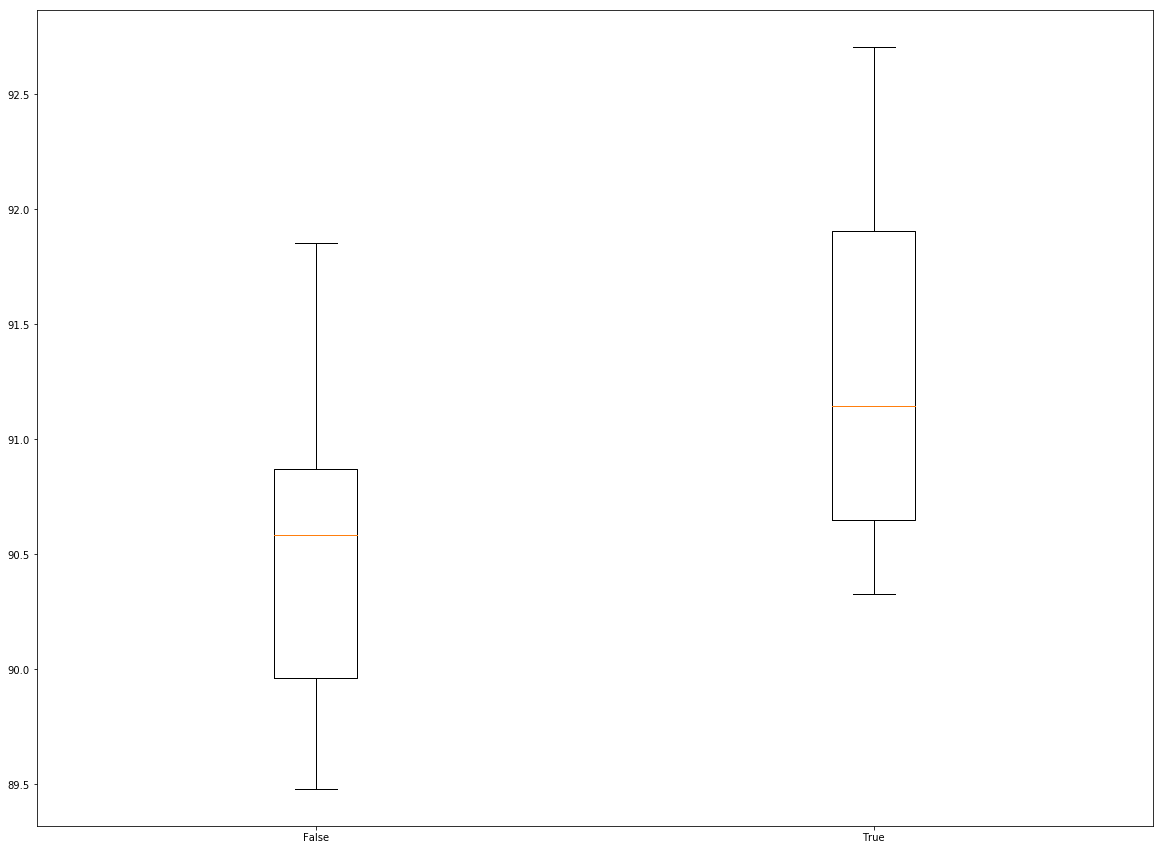

In [7]:
# cnn model with standardization for the har dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# standardize data
def scale_data(trainX, testX, standardize):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	# flatten train and test
	flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
	flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
	# standardize
	if standardize:
		s = StandardScaler()
		# fit on training data
		s.fit(longX)
		# apply to training and test data
		longX = s.transform(longX)
		flatTrainX = s.transform(flatTrainX)
		flatTestX = s.transform(flatTestX)
	# reshape
	flatTrainX = flatTrainX.reshape((trainX.shape))
	flatTestX = flatTestX.reshape((testX.shape))
	return flatTrainX, flatTestX

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, param):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# scale data
	trainX, testX = scale_data(trainX, testX, param)
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_standardize.png')

# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = []
	for p in params:
		# repeat experiment
		scores = []
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%s #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

# run the experiment
n_params = [False, True]
run_experiment(n_params)

The performance is printed for each evaluated model. At the end of the run, the performance of each of the tested configurations is summarized showing the mean and the standard deviation. We can see that it does look like standardizing the dataset prior to modeling does result in a small lift in performance from about 90.5% accuracy (close to what we saw in the previous section) to about 91.3% accuracy.

### 24.4.2 Number of Filters

An important hyperparameter for the CNN is the number of filter maps. We can experiment with a range of different values, from less to many more than the 64 used in the first model that we developed.

>p=8 #1: 87.275
>p=8 #2: 90.193
>p=8 #3: 88.429
>p=8 #4: 88.191
>p=8 #5: 88.633
>p=8 #6: 87.581
>p=8 #7: 85.579
>p=8 #8: 88.429
>p=8 #9: 88.870
>p=8 #10: 88.565
>p=16 #1: 88.633
>p=16 #2: 89.141
>p=16 #3: 92.908
>p=16 #4: 89.277
>p=16 #5: 90.940
>p=16 #6: 89.311
>p=16 #7: 91.110
>p=16 #8: 87.886
>p=16 #9: 90.261
>p=16 #10: 86.698
>p=32 #1: 90.601
>p=32 #2: 89.345
>p=32 #3: 90.431
>p=32 #4: 89.956
>p=32 #5: 88.361
>p=32 #6: 87.173
>p=32 #7: 91.856
>p=32 #8: 90.533
>p=32 #9: 90.668
>p=32 #10: 90.431
>p=64 #1: 91.415
>p=64 #2: 90.024
>p=64 #3: 90.499
>p=64 #4: 90.092
>p=64 #5: 90.906
>p=64 #6: 89.515
>p=64 #7: 90.431
>p=64 #8: 90.974
>p=64 #9: 89.854
>p=64 #10: 90.058
>p=128 #1: 91.076
>p=128 #2: 90.261
>p=128 #3: 90.431
>p=128 #4: 91.381
>p=128 #5: 90.838
>p=128 #6: 88.870
>p=128 #7: 89.956
>p=128 #8: 91.754
>p=128 #9: 91.415
>p=128 #10: 91.585
>p=256 #1: 91.211
>p=256 #2: 90.092
>p=256 #3: 92.433
>p=256 #4: 90.092
>p=256 #5: 90.567
>p=256 #6: 91.415
>p=256 #7: 92.162
>p=256 #8: 91.856
>

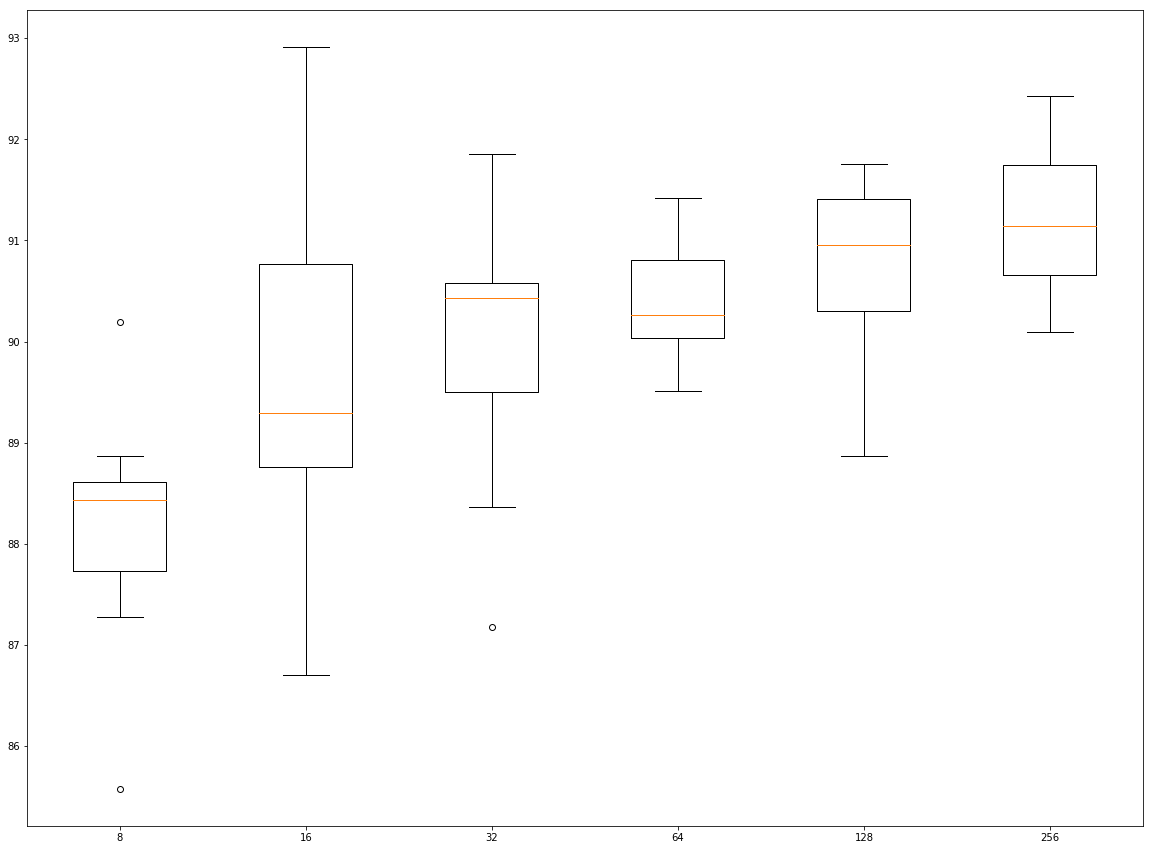

In [8]:
# cnn model with filters for the har dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
	verbose, epochs, batch_size = 0, 10, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_filters.png')

# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

We can see perhaps a trend of increasing average performance with the increase in the number of filter maps. The variance stays pretty constant, and perhaps 128 feature maps might be a good configuration for the network.

From the boxplot, we can see the trend upward in terms of median classification accuracy (orange line on the box) with the increase in the number of feature maps. We do see a dip at 64 feature maps (the default or baseline in our experiments), which is surprising, and perhaps a plateau in accuracy across 32, 128, and 256 filter maps. Perhaps 256 would be a more stable configuration.

### 24.4.3 Size of Kernel

The size of the kernel is another important hyperparameter of the 1D CNN to tune. The kernel size controls the number of time steps consider in each read of the input sequence, that is then projected onto the feature map (via the convolutional process). A large kernel size means a less rigorous reading of the data, but may result in a more generalized snapshot of the input.

>p=2 #1: 90.668
>p=2 #2: 89.447
>p=2 #3: 90.092
>p=2 #4: 90.159
>p=2 #5: 89.684
>p=2 #6: 90.804
>p=2 #7: 89.277
>p=2 #8: 90.363
>p=2 #9: 90.261
>p=2 #10: 89.650
>p=3 #1: 90.668
>p=3 #2: 90.906
>p=3 #3: 89.854
>p=3 #4: 89.006
>p=3 #5: 90.974
>p=3 #6: 89.481
>p=3 #7: 89.277
>p=3 #8: 91.551
>p=3 #9: 89.617
>p=3 #10: 92.263
>p=5 #1: 91.686
>p=5 #2: 91.449
>p=5 #3: 91.890
>p=5 #4: 90.601
>p=5 #5: 91.686
>p=5 #6: 89.379
>p=5 #7: 90.329
>p=5 #8: 90.940
>p=5 #9: 92.772
>p=5 #10: 92.467
>p=7 #1: 92.026
>p=7 #2: 91.144
>p=7 #3: 93.010
>p=7 #4: 89.515
>p=7 #5: 89.617
>p=7 #6: 91.822
>p=7 #7: 90.465
>p=7 #8: 93.417
>p=7 #9: 91.856
>p=7 #10: 92.229
>p=11 #1: 90.363
>p=11 #2: 92.162
>p=11 #3: 91.245
>p=11 #4: 92.433
>p=11 #5: 90.533
>p=11 #6: 92.433
>p=11 #7: 92.535
>p=11 #8: 92.128
>p=11 #9: 90.601
>p=11 #10: 88.463
[[90.66847641669494, 89.44689514760775, 90.09161859518154, 90.15948422124194, 89.68442483881914, 90.80420766881574, 89.27723108245674, 90.36308109942314, 90.26128266033254, 89.650492025

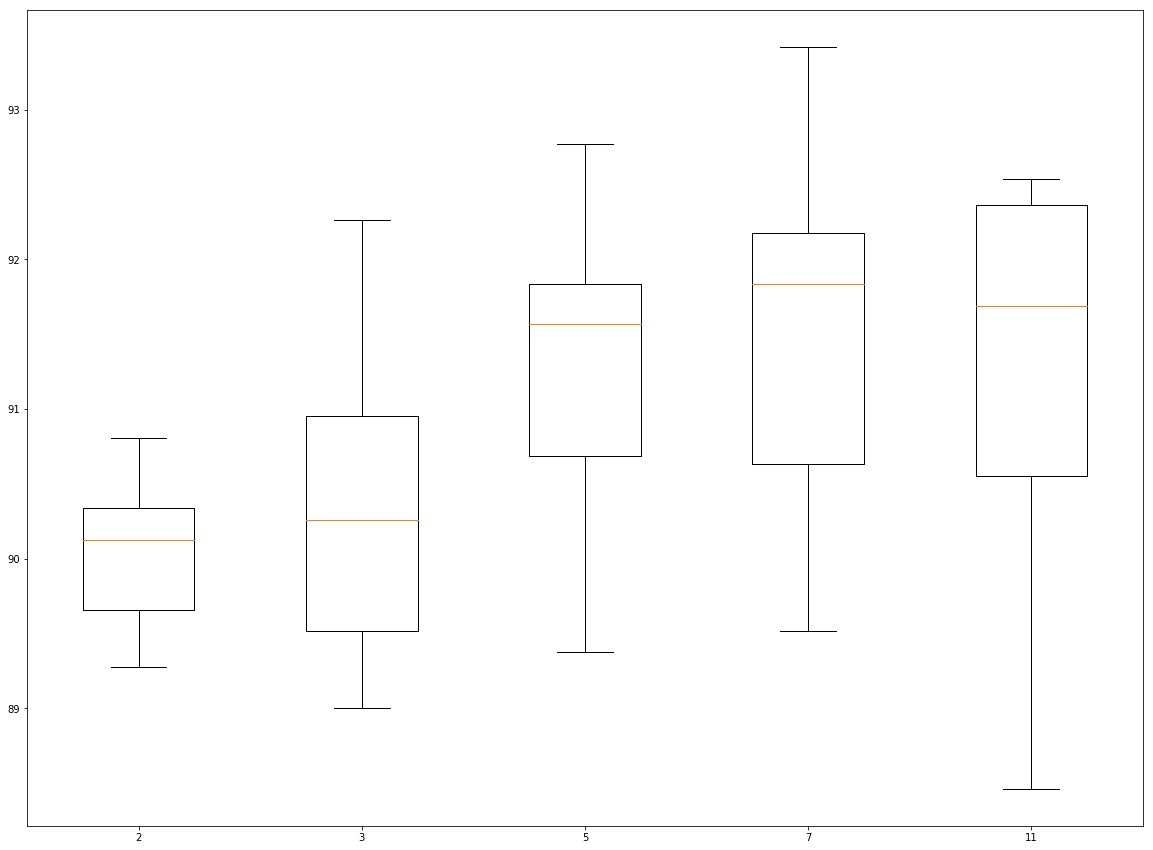

In [9]:
# cnn model vary kernel size for the har dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
	verbose, epochs, batch_size = 0, 15, 32
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	model = Sequential()
	model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
	model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
	model.add(Dropout(0.5))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(100, activation='relu'))
	model.add(Dense(n_outputs, activation='softmax'))
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	# fit network
	model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# evaluate model
	_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
	return accuracy

# summarize scores
def summarize_results(scores, params):
	print(scores, params)
	# summarize mean and standard deviation
	for i in range(len(scores)):
		m, s = mean(scores[i]), std(scores[i])
		print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
	# boxplot of scores
	pyplot.boxplot(scores, labels=params)
	pyplot.savefig('exp_cnn_kernel.png')

# run an experiment
def run_experiment(params, repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# test each parameter
	all_scores = list()
	for p in params:
		# repeat experiment
		scores = list()
		for r in range(repeats):
			score = evaluate_model(trainX, trainy, testX, testy, p)
			score = score * 100.0
			print('>p=%d #%d: %.3f' % (p, r+1, score))
			scores.append(score)
		all_scores.append(scores)
	# summarize results
	summarize_results(all_scores, params)

# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

We can see a general increase in model performance with the increase in kernel size. The results suggest a kernel size of 5 might be good with a mean skill of about 91.8%, but perhaps a size of 7 or 11 may also be just as good with a smaller standard deviation.

A box and whisker plot of the results is also created. The results suggest that a larger kernel size does appear to result in better accuracy and that perhaps a kernel size of 7 provides a good balance between good performance and low variance.

This is just the beginning of tuning the model, although we have focused on perhaps the more important elements. It might be interesting to explore combinations of some of the above findings to see if performance can be lifted even further. It may also be interesting to increase the number of repeats from 10 to 30 or more to see if it results in more stable findings.

## 24.5 Multi-headed CNN Model

Another popular approach with 1D CNNs is to have a multi-headed model, where each head of the model reads the input time steps __using a different sized kernel.__ For example, a three-headed model may have three different kernel sizes of 3, 5, 11, allowing the model to read and interpret the sequence data at three different resolutions. The interpretations from all three heads are then concatenated within the model and interpreted by a fully-connected layer before a prediction is made.

In [14]:
# multi-headed cnn model for the har dataset
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/')
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/')
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
	return trainX, trainy, testX, testy

# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    # head 1 
    inputs1 = Input(shape=(n_timesteps, n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    # head 2
    inputs2 = Input(shape=(n_timesteps, n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    # head 3 
    inputs3 = Input(shape=(n_timesteps, n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    # merge 
    merged = concatenate([flat1, flat2, flat3])
    # interpretation
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
    # save a plot of the model 
    plot_model(model, show_shapes=True, to_file='multiheaded.png')
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network 
    model.fit([trainX, trainX, trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model 
    _, accuracy = model.evaluate([testX, testX, testX], testy, batch_size=batch_size, verbose=0)
    return accuracy
    

# summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)

# run the experiment
run_experiment()

>#1: 91.483
>#2: 91.415
>#3: 93.044
>#4: 92.671
>#5: 93.824
>#6: 93.247
>#7: 93.281
>#8: 91.822
>#9: 92.433
>#10: 91.653
[91.48286392941975, 91.41499830335935, 93.04377332880895, 92.67051238547675, 93.82422802850357, 93.24737020699015, 93.28130302002036, 91.82219205972176, 92.43298269426535, 91.65252799457076]
Accuracy: 92.487% (+/-0.815)


We can see that the average performance of the model is about 92.5% classification accuracy with a standard deviation of about 0.8. This example may be used as the basis for exploring a variety of other models that vary different model hyperparameters and even different data preparation schemes across the input heads.

It would not be an apples-to-apples comparison to compare this result with a single-headed CNN given the relative tripling of the resources in this model. Perhaps an apples-to-apples comparison would be a model with the same architecture and the same number of filters across each input head of the model.

## 24.7 Further Reading
This section provides more resources on the topic if you are looking to go deeper.
- Getting started with the Keras Sequential model. https://keras.io/getting-started/sequential-model-guide/
- Getting started with the Keras functional API. https://keras.io/getting-started/functional-api-guide/
- Keras Sequential Model API. https://keras.io/models/sequential/
- Keras Core Layers API. https://keras.io/layers/core/
- Keras Convolutional Layers API. https://keras.io/layers/convolutional/
- Keras Pooling Layers API. https://keras.io/layers/pooling/

## 24.8 Summary
In this tutorial, you discovered how to develop one-dimensional convolutional neural networks for time series classification on the problem of human activity recognition. Specifically, you learned:
- How to load and prepare the data for a standard human activity recognition dataset and develop a single 1D CNN model that achieves excellent performance on the raw data.
- How to further tune the performance of the model, including data transformation, filter maps, and kernel sizes.
- How to develop a sophisticated multi-headed one-dimensional convolutional neural network model that provides an ensemble-like result.